In [1]:
%matplotlib inline

import os
import numpy as np

from analysis.models.vr import RatCAVESession
from analysis.plots.placecells import double_place_field_plot, unit_place_firing_with_autocorr


# interesting sessions for 002430
s_002430 = [
    "2019-02-14_11-29-08",  # nothing
    "2019-02-14_16-34-47",  # nothing
    "2019-02-15_15-46-05",  # 3-2, 3-4, putative
    "2019-02-15_21-12-17",  # 3-4 putative
    "2019-02-16_09-39-47",  # 5-2, no 180 turn
    "2019-02-17_15-26-41",  # nothing
    "2019-02-18_16-17-26",  # 1-2 putative
    "2019-02-19_16-21-36",  # nothing
]

# interesting sessions for 002431
s_002431 = [
    "2019-02-19_10-28-29",  # 2-2
    "2019-02-19_15-20-09",  # nothing
    "2019-02-19_16-59-14",  # 3-2?, 4-2!
    "2019-02-20_11-34-39",  # nothing
    "2019-04-16_10-49-18",  # 3-2, 3-5, 3-9, 6-3, 6-7
    "2019-04-16_15-36-38"   # 4-3, 6-5
    "2019-04-17_09-45-50"   # 4-2, 6-2 no corner, 6-6, 6-8
]

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '002431'
session_id = '2019-04-16_10-49-18'

sessionpath = os.path.join(source, animal, session_id)

session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes()[0]

# Overview

In [4]:
session.tetrode_unit_map

{1: [],
 2: [],
 3: [2, 3, 4, 5, 6, 7, 8, 9, 10],
 4: [],
 5: [],
 6: [2, 3, 4, 5, 6, 7, 8, 9],
 7: [],
 8: []}

In [13]:
# fetching positions and autocorrs
all_pos = session.trajectory[:, 1:3]
unit_pos_dict = session.get_unit_positions_with_autocorrs(running_idxs)

Completed.


Processing unit group 6..

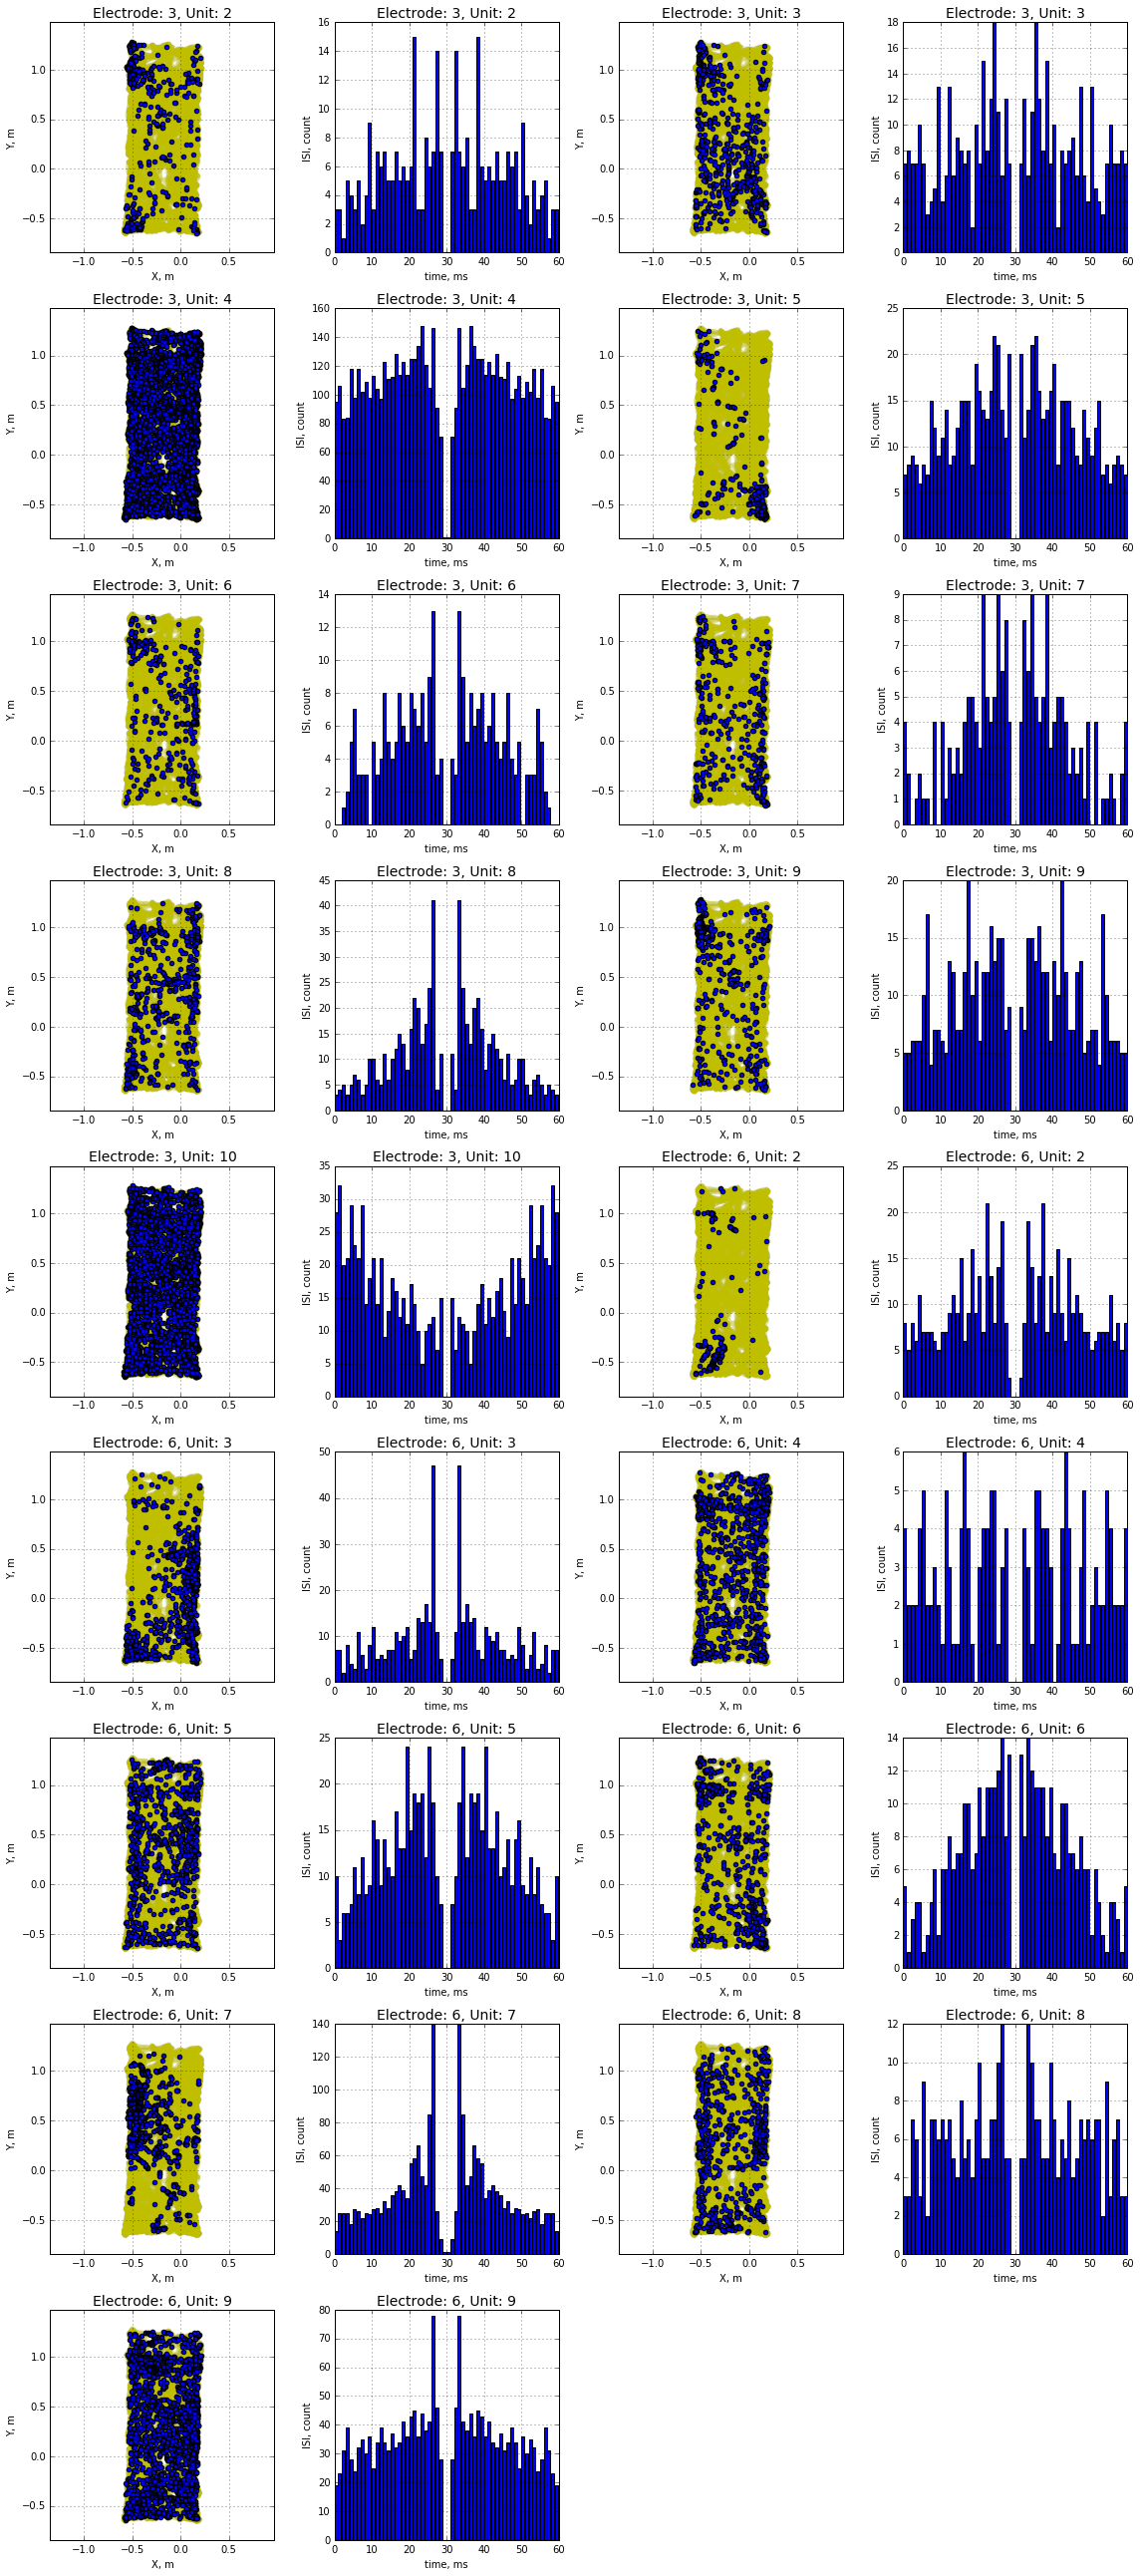

In [28]:
# drawing small plots
fig = unit_place_firing_with_autocorr(all_pos, unit_pos_dict, per_row=4)

filename = "unit_firing_maps_with_autocorr.png"
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

TTD 6 Unit 7 completed


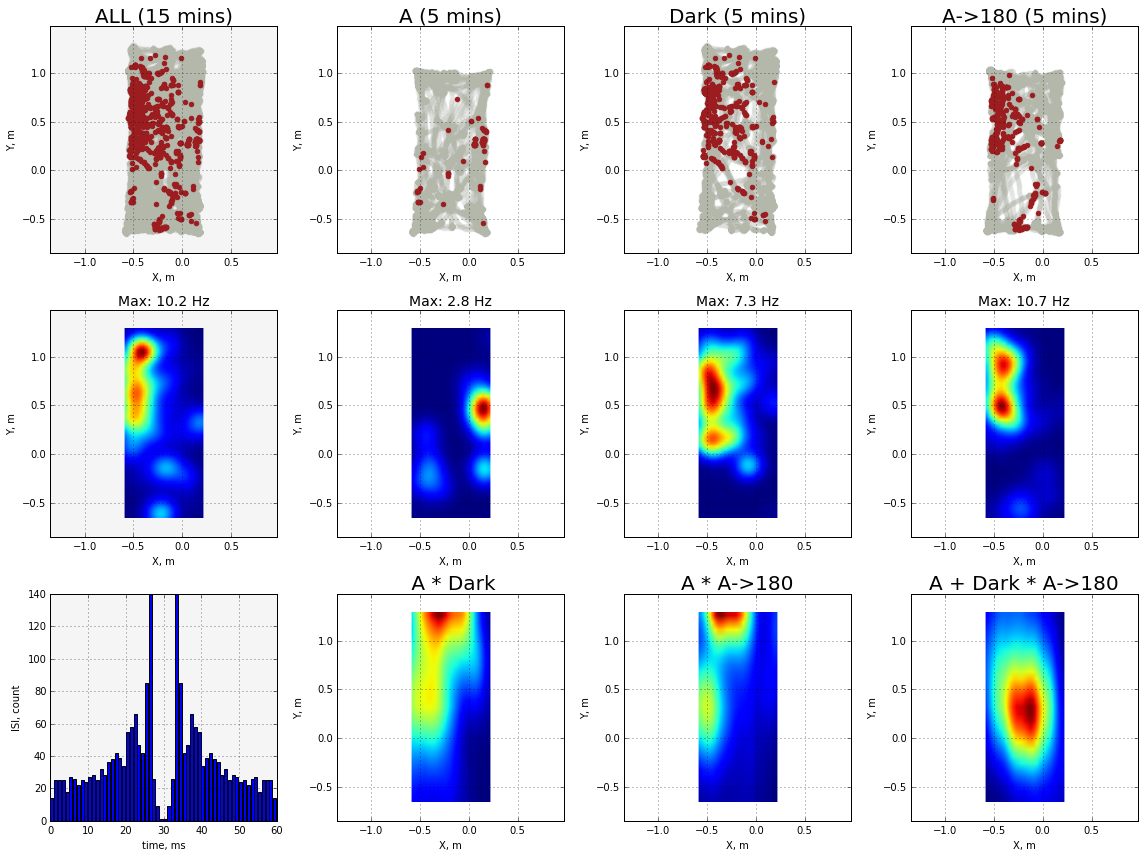

In [4]:
from analysis.plots.placecells import draw_place_field, draw_place_firing, draw_autocorrelogram
from analysis.plots.placecells import get_figure_size, get_extent
from analysis.models.analytics import place_field_2D
from matplotlib.pyplot import figure
from scipy.signal import correlate2d

sampling_rate = 50

# for ttd, units in session.tetrode_unit_map.items():
#     for unit in units:
        
ttd = 6
unit = 7

fig = figure(figsize=(4 * 4, 4 * 3))

limits = get_figure_size(session.trajectory[:, 1:3])
extent = get_extent(session.trajectory[:, 1:3])

trajectory = session.trajectory
unit_fire = session.get_positions_for_unit(ttd, unit, running_idxs)
spiket = session.get_unit_firing_at_freq(ttd, unit, sampling_rate)
pos_at_f = session.get_positions_at_freq(sampling_rate)


p1 = (session.t_start, session.t_end)                      # whole session
p2 = (session.t_start, session.t_start + 5 * 60)           # first 4 minutes
p3 = (session.t_start + 5 * 60, session.t_start + 10 * 60) # 2 minutes in dark
p4 = (session.t_start + 10 * 60, session.t_end)            # last 4 min 180 rotated

titles = ['ALL (15 mins)', 'A (5 mins)', 'Dark (5 mins)', 'A->180 (5 mins)']
firing_fields = []

for i, period in enumerate([p1, p2, p3, p4]):
    t_start = period[0] - session.t_start
    t_end = period[1] - session.t_start

    # place spiking data
    walk = trajectory[(trajectory[:, 0] > period[0]) & (trajectory[:, 0] < period[1])][:, 1:3]
    fire = unit_fire[(unit_fire[:, 0] > period[0]) & (unit_fire[:, 0] < period[1])][:, 1:3]

    ax = fig.add_subplot(3, 4, i + 1)
    draw_place_firing(ax, walk, fire, limits=limits)
    #title = "Period %s - %s" % (int(t_start), int(t_end))
    ax.set_title(titles[i], fontsize=20)

    ax.set_aspect('equal')
    if i == 0:
        ax.set_axis_bgcolor('whitesmoke')

    # place field data
    idx_start = int((period[0] - session.t_start) * sampling_rate)
    idx_end = int((period[1] - session.t_start) * sampling_rate)

    pos = pos_at_f[idx_start:idx_end]
    st = spiket[(spiket > idx_start) & (spiket < idx_end)]
    omap, smap, fmap, s_firing_map = place_field_2D(pos, st - idx_start, sampling_rate, 0.03)
    firing_fields.append(s_firing_map)

    ax = fig.add_subplot(3, 4, i + 5)
    draw_place_field(ax, s_firing_map, limits, extent)
    ax.set_title("Max: %2.1f Hz" % (s_firing_map.max()), fontsize=14)
    if i == 0:
        ax.set_axis_bgcolor('whitesmoke')


# autocorr    
ax = fig.add_subplot(3, 4, 9)
ax.set_axis_bgcolor('whitesmoke')
draw_autocorrelogram(ax, session.get_autocorr(ttd, unit))

# cross-corrs
idx_start = int((p2[0] - session.t_start) * sampling_rate)
idx_end = int((p3[1] - session.t_start) * sampling_rate)

pos = pos_at_f[idx_start:idx_end]
st = spiket[(spiket > idx_start) & (spiket < idx_end)]
omap, smap, fmap, s_firing_map = place_field_2D(pos, st - idx_start, sampling_rate, 0.03)


cc1 = correlate2d(firing_fields[1], firing_fields[2], mode='same')
cc2 = correlate2d(firing_fields[1], firing_fields[3], mode='same')
cc3 = correlate2d(s_firing_map, firing_fields[3], mode='same')
titles = [' A * Dark', 'A * A->180', 'A + Dark * A->180']

for i, cci in enumerate([cc1, cc2, cc3]):
    ax = fig.add_subplot(3, 4, i + 10)
    draw_place_field(ax, cci.T, limits=limits, extent=extent)
    ax.set_title(titles[i], fontsize=20)

fig.tight_layout()

filename = "ttd_%s_unit_%s_180.png" % (ttd, unit)
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

print("TTD %s Unit %s completed" % (ttd, unit))

# Place activity before (6m) and after (4m) 180 rotation

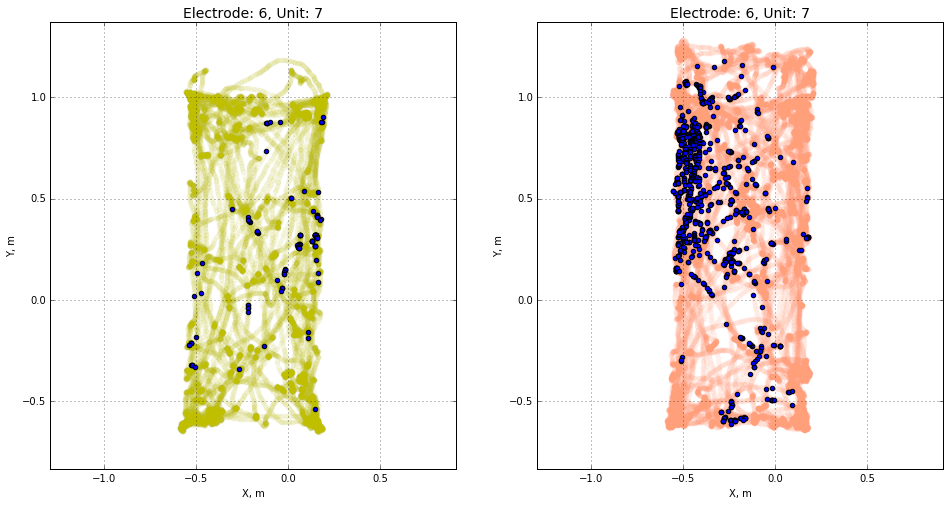

In [14]:
t0 = session.trajectory[0][0]
t1 = t0 + 360  # time when the world rotates 180deg in seconds
ttd = 6
unit = 7

unit_fire = session.get_positions_for_unit(ttd, unit, running_idxs)

walk_A = session.trajectory[session.trajectory[:, 0] < t1][:, 1:3]
fire_A = unit_fire[unit_fire[:, 0] < t1][:, 1:3]

walk_B = session.trajectory[session.trajectory[:, 0] > t1][:, 1:3]
fire_B = unit_fire[unit_fire[:, 0] > t1][:, 1:3]


title = "Electrode: %s, Unit: %s" % (ttd, unit)
fig = double_place_field_plot(walk_A, fire_A, walk_B, fire_B, title)

#filename = "ttd_%s_unit_%s_180.png" % (ttd, unit)
#fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

In [12]:
RatCAVESession.__file__

AttributeError: type object 'RatCAVESession' has no attribute '__file__'